In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id = "14gqrzGcdPg4ImOEiica-vV-ri48ww5ba"

In [4]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data')  
data = pd.read_csv('data')

In [5]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [6]:
y = data["DEATH_EVENT"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("DEATH_EVENT",axis=1), y, test_size=0.3, random_state=42)

In [8]:
X_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
224,58.000,0,582,1,25,0,504000.00,1.0,138,1,0,205
68,70.000,0,161,0,25,0,244000.00,1.2,142,0,0,66
222,42.000,1,86,0,35,0,365000.00,1.1,139,1,1,201
37,82.000,1,855,1,50,1,321000.00,1.0,145,0,0,30
16,87.000,1,149,0,38,0,262000.00,0.9,140,1,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...
188,60.667,1,151,1,40,1,201000.00,1.0,136,0,0,172
71,58.000,0,582,1,35,0,122000.00,0.9,139,1,1,71
106,55.000,0,748,0,45,0,263000.00,1.3,137,1,0,88
270,44.000,0,582,1,30,1,263358.03,1.6,130,1,1,244


Check data imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


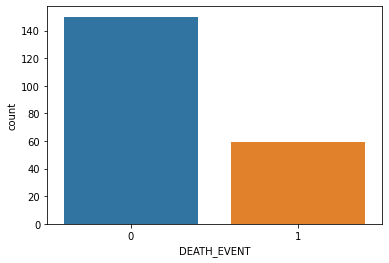

In [9]:
sns.countplot(y_train) 

Data is imbalance, need to smote

#EDA

# numerical variables


Age

In [11]:
X_train['age'].unique()

array([58.   , 70.   , 42.   , 82.   , 87.   , 86.   , 45.   , 40.   ,
       72.   , 75.   , 65.   , 85.   , 47.   , 60.   , 55.   , 63.   ,
       80.   , 61.   , 50.   , 78.   , 95.   , 68.   , 43.   , 73.   ,
       59.   , 69.   , 49.   , 53.   , 79.   , 62.   , 51.   , 57.   ,
       52.   , 46.   , 56.   , 90.   , 41.   , 67.   , 54.   , 44.   ,
       81.   , 77.   , 66.   , 64.   , 60.667])

60.667 seems weird

In [12]:
X_train[X_train["age"]==60.667] # only 1 row

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
188,60.667,1,151,1,40,1,201000.0,1.0,136,0,0,172


In [13]:
X_train.loc[188,'age'] = 61

In [14]:
X_train.loc[188,'age']

61.0

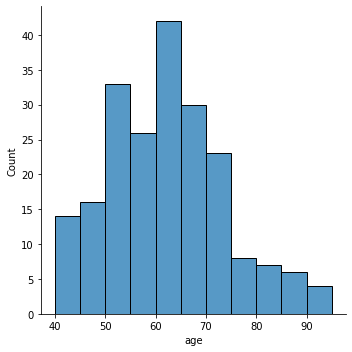

In [15]:
sns.displot(X_train['age'])

creatinine_phosphokinase

In [16]:
X_train['creatinine_phosphokinase'].describe() # maximum outliers

count     209.000000
mean      575.320574
std       925.957679
min        23.000000
25%       110.000000
50%       245.000000
75%       582.000000
max      7861.000000
Name: creatinine_phosphokinase, dtype: float64

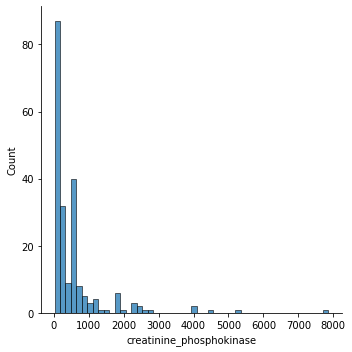

In [17]:
sns.displot(X_train['creatinine_phosphokinase'])

In [18]:
sum(X_train['creatinine_phosphokinase']>3000)  # only 5 ppl have creatine phosphokinase>3000)

5

In [19]:
sum(X_train['creatinine_phosphokinase']>1000)  # only 27 ppl have creatine phosphokinase>1000) about 10% of train data

27

Keep outliers as might hold important information


ejection fraction

In [20]:
X_train['ejection_fraction'].describe()  # looks normal

count    209.000000
mean      38.411483
std       11.571810
min       20.000000
25%       30.000000
50%       38.000000
75%       45.000000
max       80.000000
Name: ejection_fraction, dtype: float64

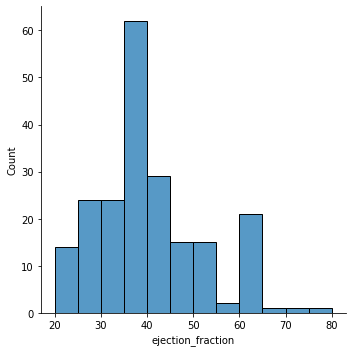

In [21]:
sns.displot(X_train['ejection_fraction'])

platelets


In [22]:
X_train['platelets'].describe() #looks normal

count       209.000000
mean     262121.389713
std       91141.626476
min       62000.000000
25%      210000.000000
50%      263000.000000
75%      305000.000000
max      621000.000000
Name: platelets, dtype: float64

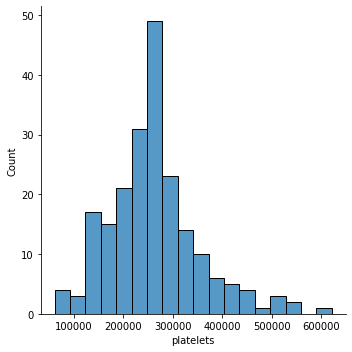

In [23]:
sns.displot(X_train['platelets'])

serum creatinine

In [24]:
X_train['serum_creatinine'].describe() # maximum outliers

count    209.000000
mean       1.373062
std        1.000018
min        0.500000
25%        0.900000
50%        1.100000
75%        1.400000
max        9.000000
Name: serum_creatinine, dtype: float64

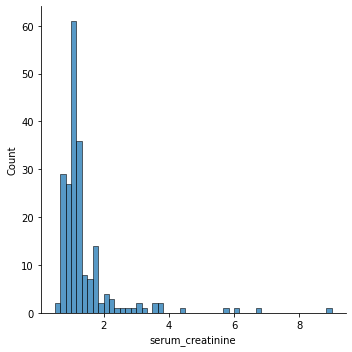

In [25]:
sns.displot(X_train['serum_creatinine'])

In [26]:
sum(X_train['serum_creatinine']>2) # 10% of data is outlier

22

serum sodium

In [27]:
X_train['serum_sodium'].describe()

count    209.000000
mean     136.717703
std        4.318088
min      113.000000
25%      134.000000
50%      137.000000
75%      140.000000
max      146.000000
Name: serum_sodium, dtype: float64

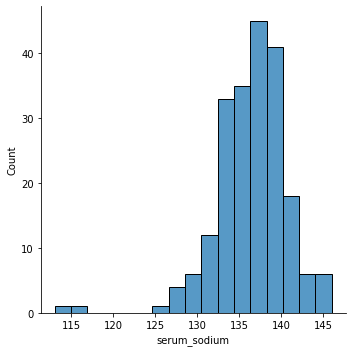

In [28]:
sns.displot(X_train['serum_sodium']) # minimum outliers

In [29]:
sum(X_train['serum_sodium']<120)

2

Time

In [30]:
X_train['time'].describe()

count    209.000000
mean     133.545455
std       78.094919
min        4.000000
25%       76.000000
50%      119.000000
75%      206.000000
max      285.000000
Name: time, dtype: float64

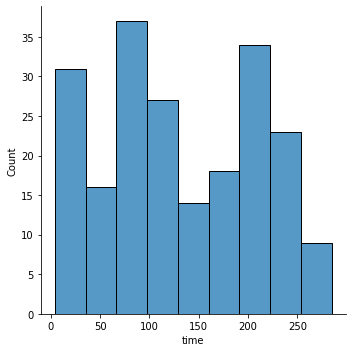

In [31]:
sns.displot(X_train['time']) # weird distribution

Check if outlier of individual features are common ppl

In [32]:
X_train[(X_train['creatinine_phosphokinase']>1000) & (X_train['serum_creatinine']>2)] # all 4 ppl are 60 

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
38,60.0,0,2656,1,30,0,305000.00,2.3,137,1,0,30
131,60.0,1,1082,1,45,0,250000.00,6.1,131,1,0,107
52,60.0,0,3964,1,62,0,263358.03,6.8,146,0,0,43
187,60.0,0,1896,1,25,0,365000.00,2.1,144,0,0,172


# Relationship between numerical variables and response

In [33]:
num_var = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

In [34]:
X_num  = X_train.copy()
X_num['death'] = y_train

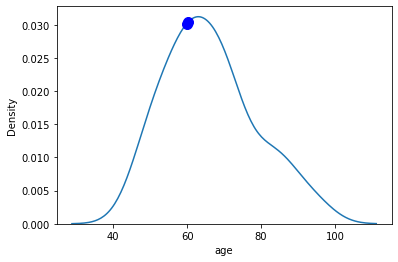

In [37]:
# testing plot point on kde plot
ax = sns.kdeplot(X_num[X_num['death']==1]['age'])
x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
point_id = np.where(x.round()==60)

plt.plot(x[point_id],y[point_id],'bo',ms=10)


64


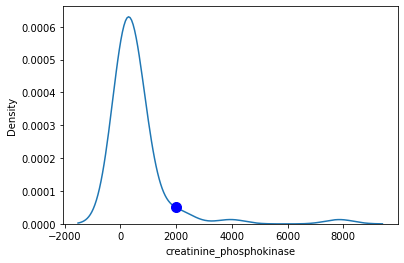

In [38]:
# testing plot point on kde plot
ax = sns.kdeplot(X_num[X_num['death']==1]['creatinine_phosphokinase'])
x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
point_id = find_nearest(x,2000)
print(point_id)
plt.plot(x[point_id],y[point_id],'bo',ms=10)

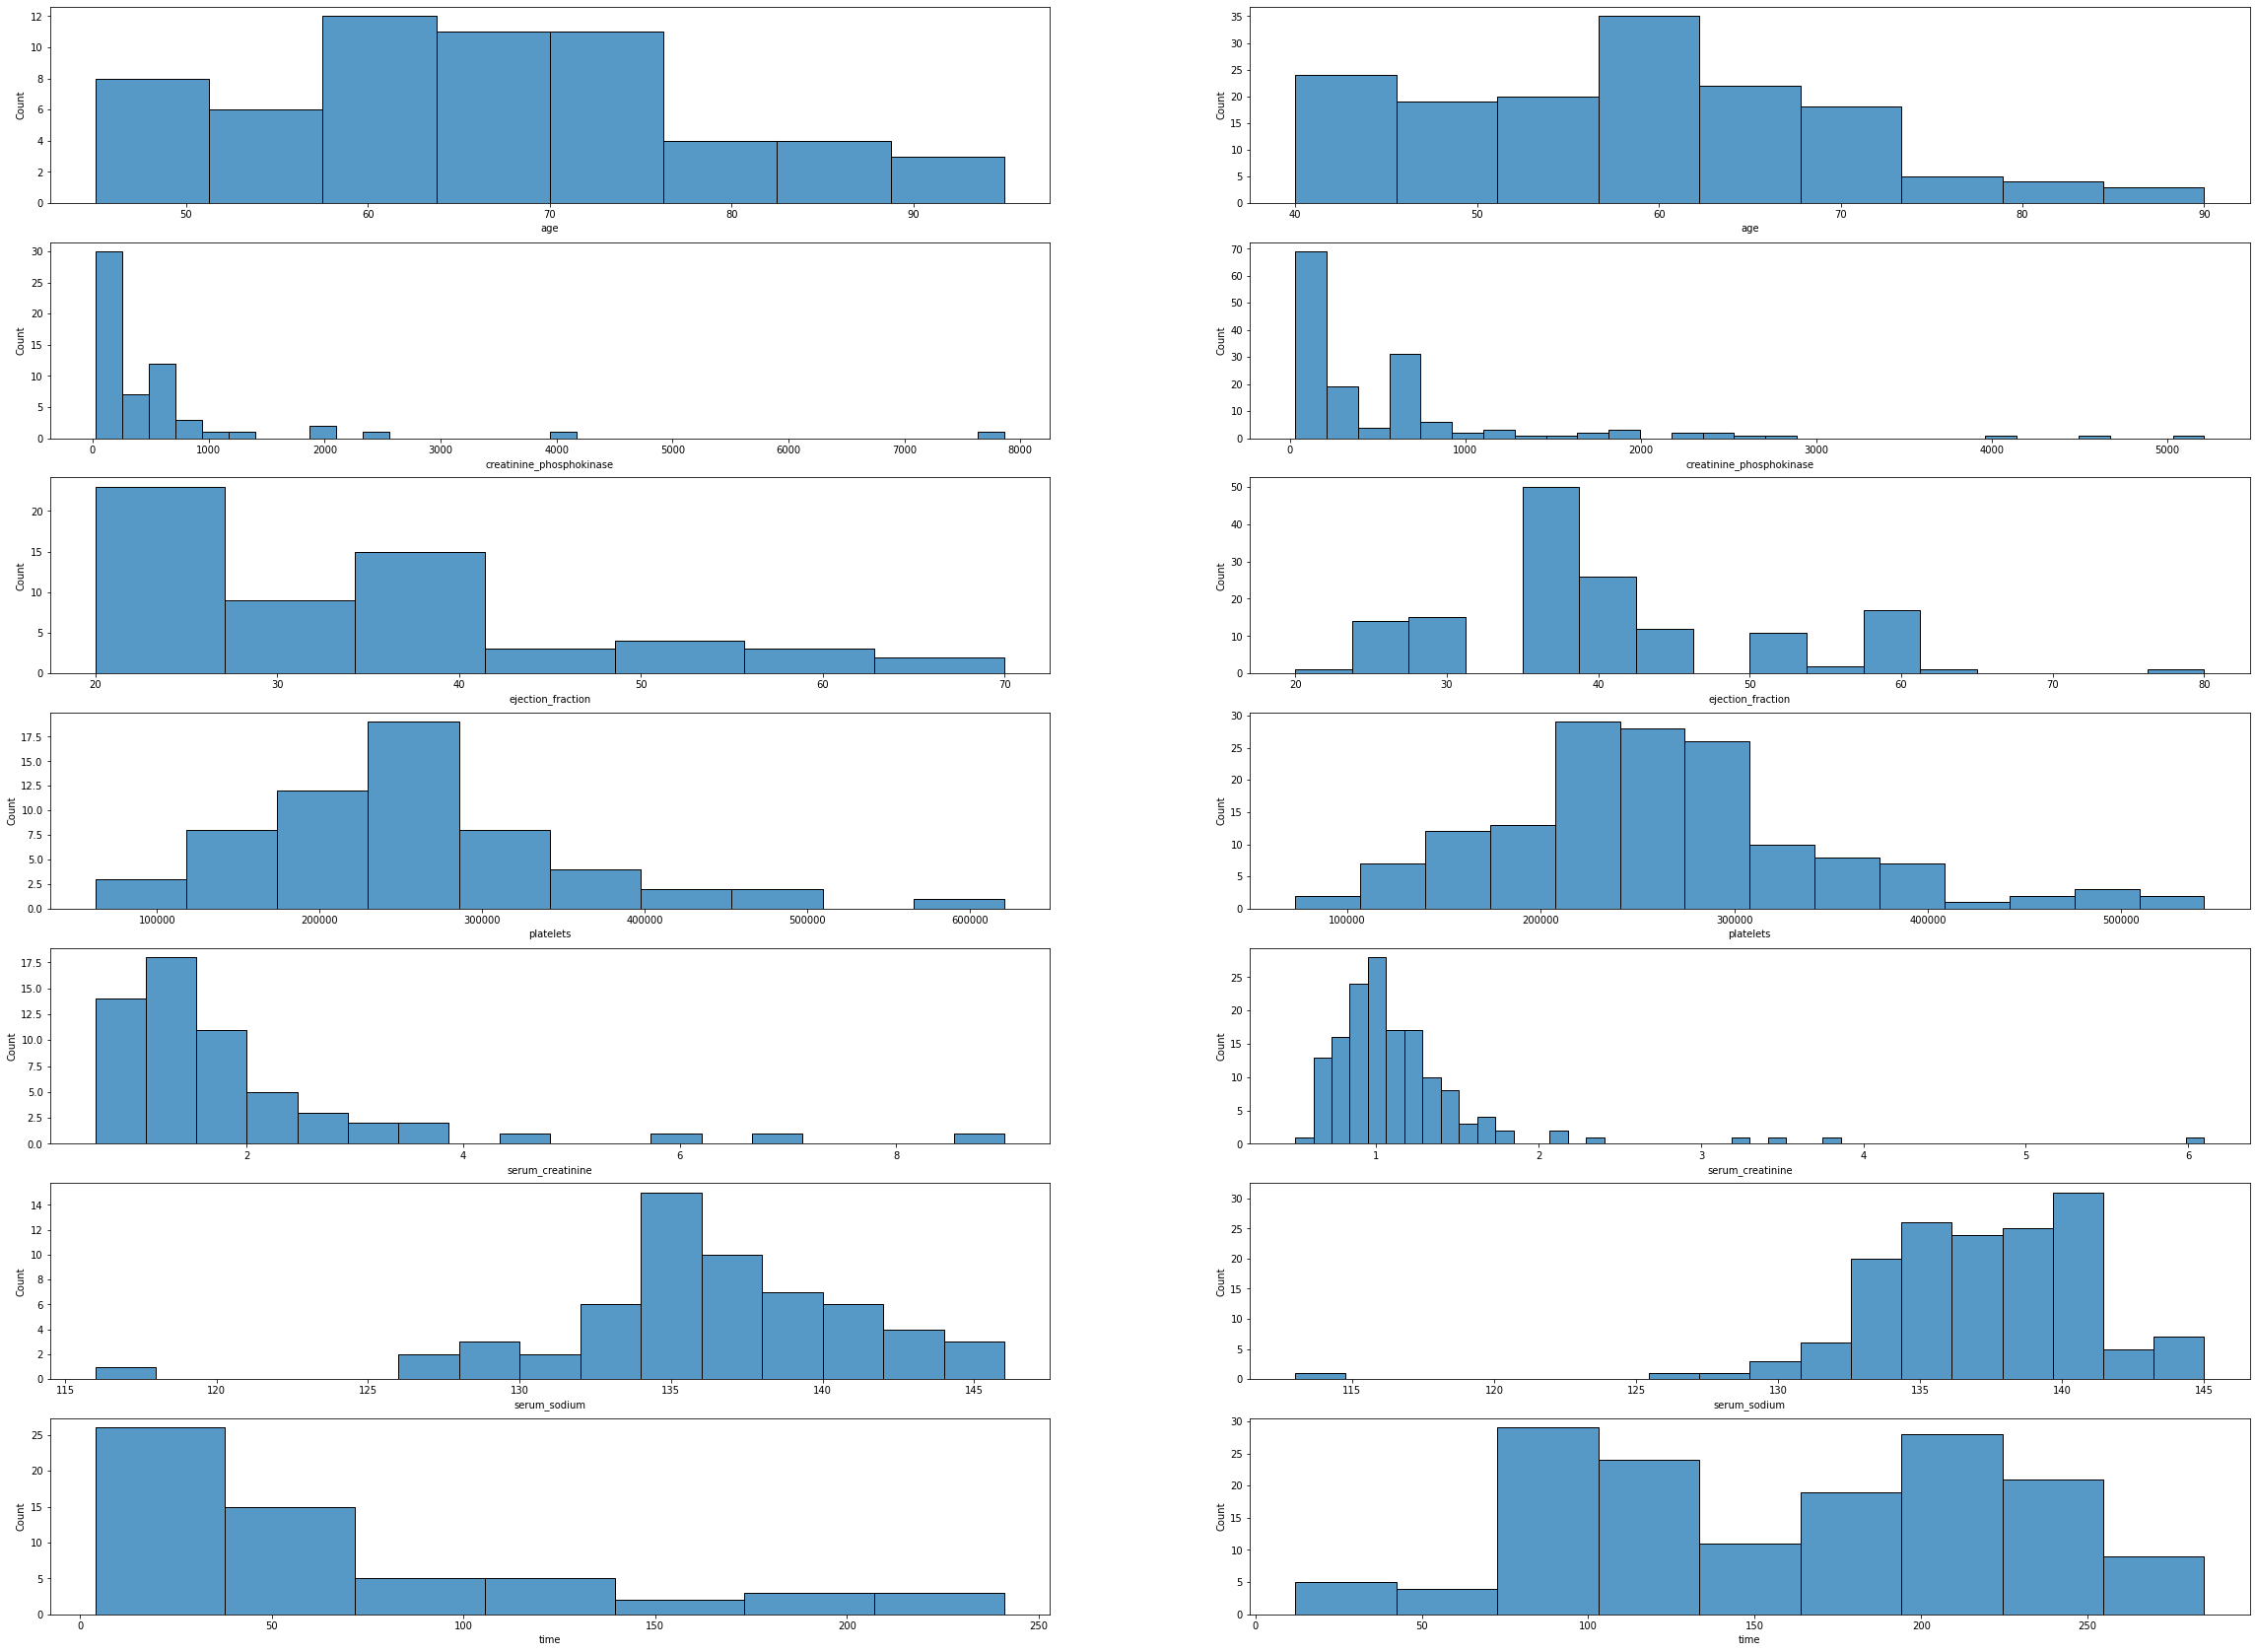

In [39]:
fig, axes = plt.subplots(7, 2, figsize=(40, 30))
r=0
for i in num_var:
  sns.histplot(X_num[X_num['death']==1][i],ax=axes[r,0])
  sns.histplot(X_num[X_num['death']==0][i],ax=axes[r,1])
  r+=1

age, ejection fraction, serum_sodium, time seem important in predicting death

# Relationship between categorical variables and response

In [40]:
cat_var = ['anaemia','diabetes','high_blood_pressure','sex','smoking']

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


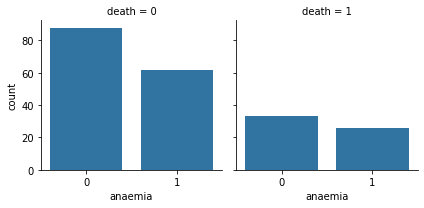

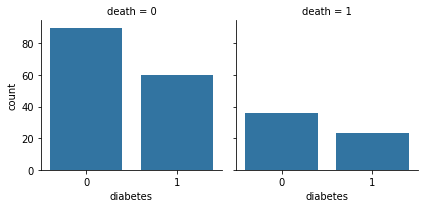

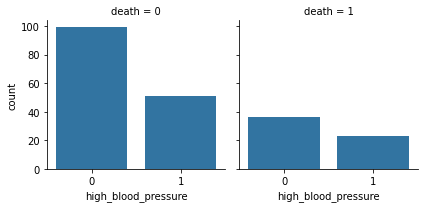

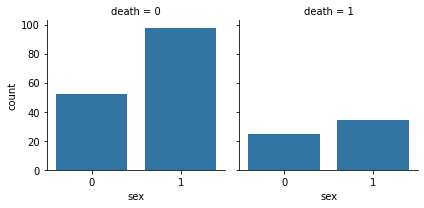

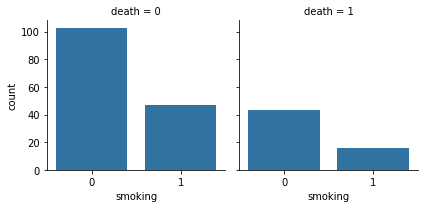

In [41]:
for i in cat_var:
  g = sns.FacetGrid(data=X_num, col='death')
  g.map(sns.countplot,i)

Except for smoking, other categorical variables seem to have diiferent distributions for death

# Correlation between variables

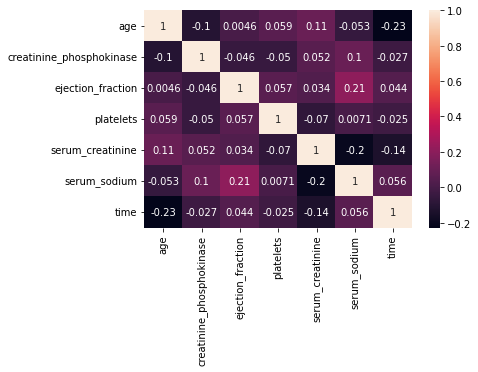

In [42]:
sns.heatmap(X_train[num_var].corr(),annot = True) # no strong correlation between numerical variables

In [43]:
# Find Point biserial correlation
for i in cat_var:
  for j in  num_var:
    data_cat = X_train[i].to_numpy()
    data_cont = X_train[j].to_numpy()
    
    corr, p_val = pointbiserialr(x=data_cat, y=data_cont)
    if np.abs(corr) >= 0.4:
      print(f'Categorical variable: {i}, Continuous variable: {j}, correlation: {corr}')

In [44]:
# Find Cramer's V correlation
total_len = len(cat_var)
for idx1 in range(total_len-1):
  for idx2 in range(idx1+1, total_len):
    cat_var1 = cat_var[idx1]
    cat_var2 = cat_var[idx2]    
    c_matrix = pd.crosstab(X_train[cat_var1], X_train[cat_var2])

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(c_matrix)[0]
    n = c_matrix.sum().sum()
    phi2 = chi2/n
    r,k = c_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    corr = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    if corr >= 0.3:
      print(f'categorical variable 1: {cat_var1}, categorical variable 2: {cat_var2}, correlation: {corr}')

categorical variable 1: sex, categorical variable 2: smoking, correlation: 0.4213890217044651


No variables need to be removed

#Smote

In [45]:
index= []
for i in cat_var:
  index.append(X_train.columns.get_loc(i))

In [46]:
smote_nc = SMOTENC(random_state=111, categorical_features=index)
X_train, y_train =  smote_nc.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


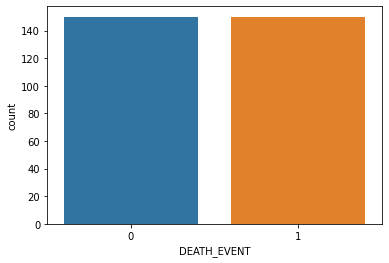

In [47]:
sns.countplot(y_train)

# K means clustering

In [48]:
df_num = X_train.copy()[num_var]

In [49]:
df_num.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0,58.0,582,25,504000.0,1.0,138,205
1,70.0,161,25,244000.0,1.2,142,66
2,42.0,86,35,365000.0,1.1,139,201
3,82.0,855,50,321000.0,1.0,145,30
4,87.0,149,38,262000.0,0.9,140,14


In [50]:
#if the columns are too skewed, this is a method that scales each column of a dataframe, the output is a numpy array 
dataarray = df_num.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

In [51]:
wcss = []
max_k = 10 # NOTE: Try 10 and 20
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

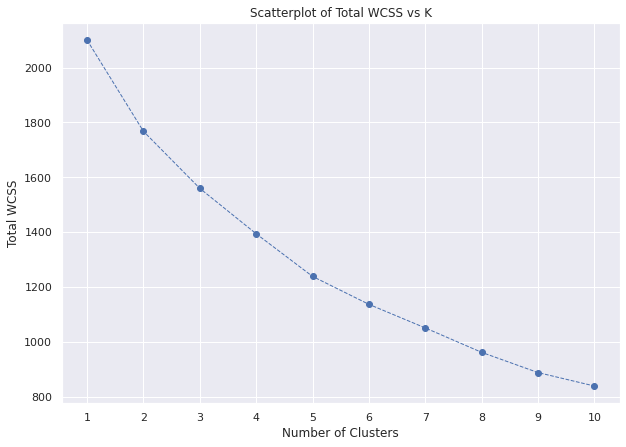

In [52]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

Clustering is probably not useful as there is no elbow


In [53]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

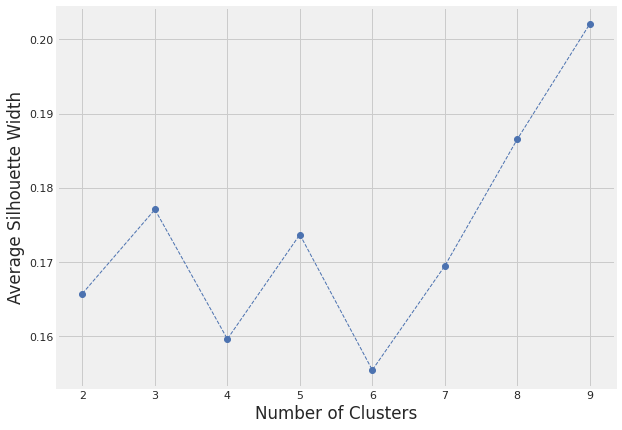

In [54]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

try 3 clusters

In [55]:
kmeans3 = KMeans(init="random",n_clusters = 3, random_state = 42)
kmeans3.fit(scaled_features)
clustergroups3 = kmeans3.labels_ #The cluster number for each row

In [56]:
df_num["cluster"] = clustergroups3

In [57]:
df_num.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,cluster
0,58.0,582,25,504000.0,1.0,138,205,0
1,70.0,161,25,244000.0,1.2,142,66,1
2,42.0,86,35,365000.0,1.1,139,201,0
3,82.0,855,50,321000.0,1.0,145,30,0
4,87.0,149,38,262000.0,0.9,140,14,1


In [58]:
def plot_boxplots(data_with_label):
  plt.figure(figsize=(30,30))
  sns.set(font_scale = 2)
  for i in range(len(data_with_label.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=data_with_label.columns[i], x='cluster', data=data_with_label, palette="colorblind") 


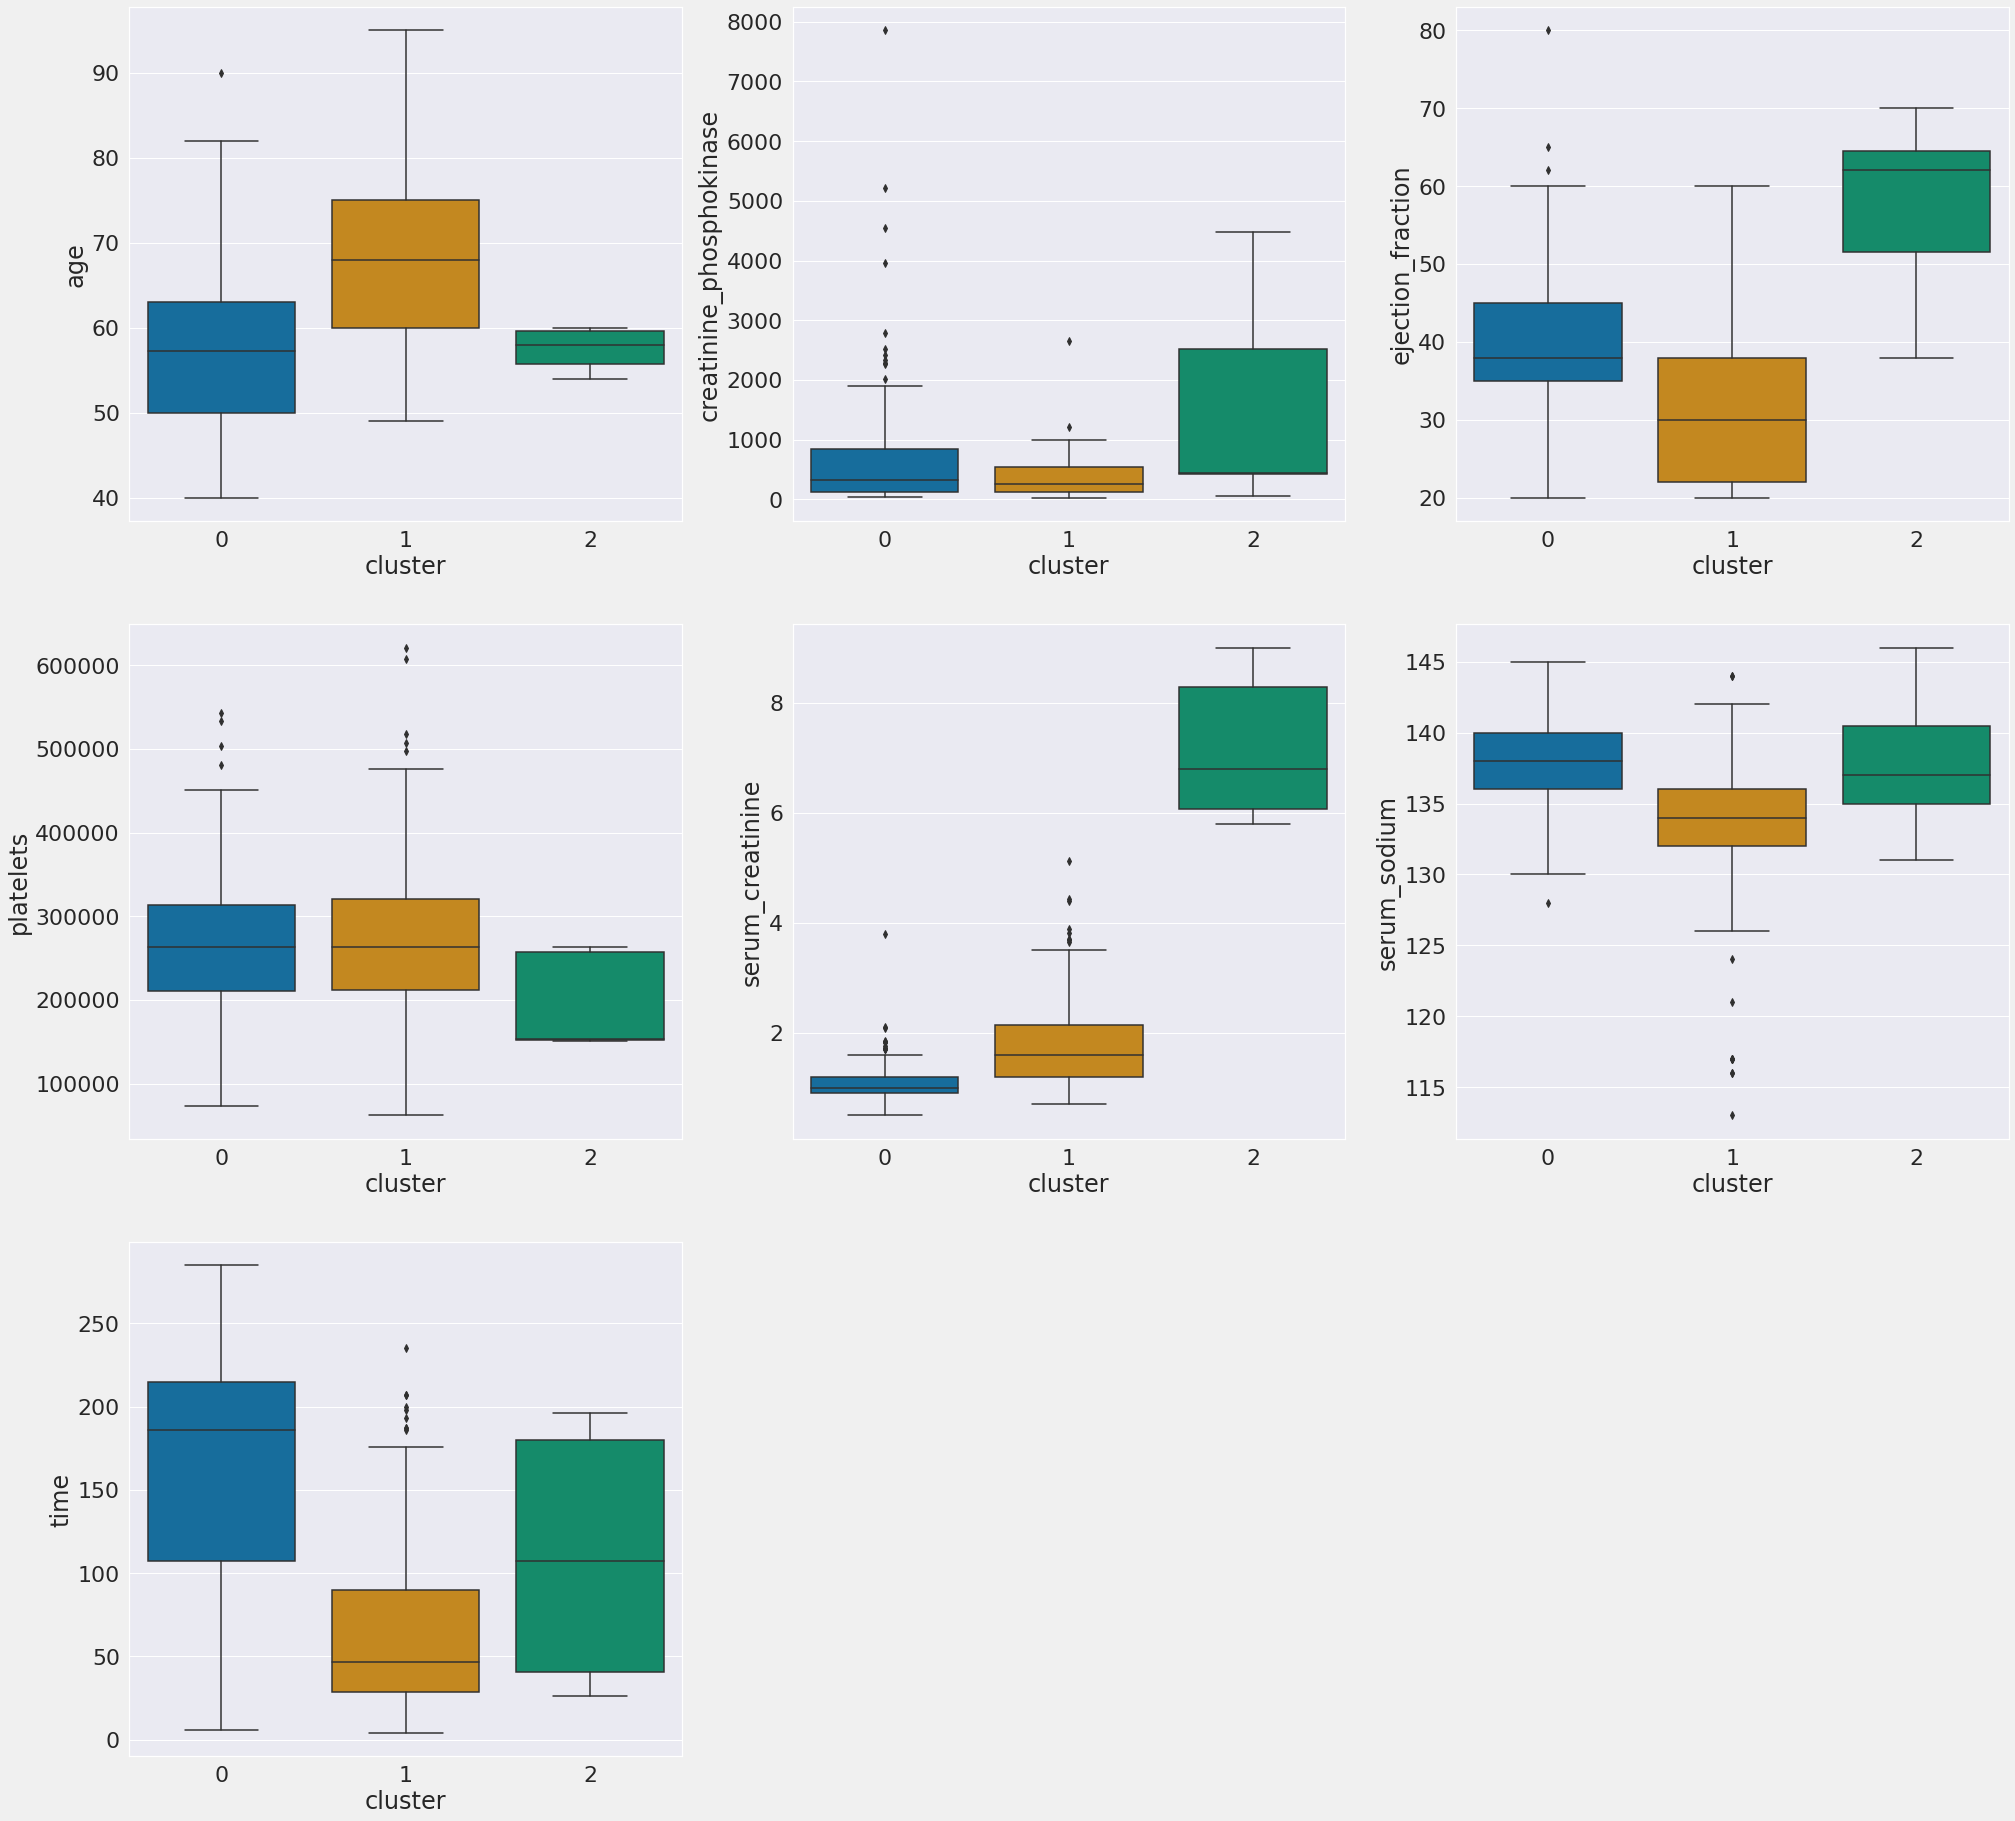

In [59]:
plot_boxplots(df_num)

In [60]:
df_num['cluster'].value_counts()

1    148
0    145
2      7
Name: cluster, dtype: int64

clustering is not useful

# Models

In [61]:
def metrics(test_data, prediction):
  cm = pd.DataFrame(confusion_matrix(test_data, prediction))
  cm.columns = ['Predicted Y=0','Predicted Y=1']
  cm.index = ['True Y=0','True Y=1']
  display(cm)

  accuracy = (cm.iloc[0,0]+cm.iloc[1,1])/(cm.iloc[0,0]+cm.iloc[1,1]+cm.iloc[0,1]+cm.iloc[1,0])
  print('Accuracy: '+str(accuracy))

  # Possible ways to further improve accuracy is to try adjusting the level of significance.

  # Calculate Sensitivity (true positive rate)
  sensitivity = cm.iloc[1, 1]/(cm.iloc[1, 1] + cm.iloc[1, 0])
  print('Sensitivity: '+ str(sensitivity))

  # Calculate Specificity (true negative rate)
  specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[0, 1])
  print('Specificity: '+str(specificity))

  #Precision
  precision = cm.iloc[1,1]/(cm.iloc[1,1]+cm.iloc[0,1])
  print('Precision: '+str(precision))

  # AUC
  print('ROC-AUC:',roc_auc_score(test_data, prediction))

  #F1 Score
  print("F1 score:", round(f1_score(test_data, prediction), 4))

# Logistic Regression

In [62]:
logreg_train_data  = X_train.copy()
logreg_train_data['death'] = y_train

In [63]:
all_predictors = "+".join(logreg_train_data.drop('death',axis=1).columns)
print(all_predictors)

age+anaemia+creatinine_phosphokinase+diabetes+ejection_fraction+high_blood_pressure+platelets+serum_creatinine+serum_sodium+sex+smoking+time


In [64]:
f = 'death ~ '+all_predictors
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.297982
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                           12
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5701
Time:                        06:52:35   Log-Likelihood:                -89.395
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 6.660e-44
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   15.0213      6.866      2.188      0.029       1.564

In [65]:
droplist = ['death']

def remove_name_formula(toremove):
    print(type(toremove))
    global droplist
    droplist = droplist+toremove
    newdf = logreg_train_data.drop(droplist,axis=1)
    predictors = "+".join(newdf.columns)
    f = 'death ~ '+predictors
    return f

In [66]:
f = remove_name_formula(['diabetes'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.298031
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      288
Method:                           MLE   Df Model:                           11
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5700
Time:                        06:52:38   Log-Likelihood:                -89.409
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 1.416e-44
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.8295      6.773      2.189      0.

In [67]:
f = remove_name_formula(['platelets'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.298310
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      289
Method:                           MLE   Df Model:                           10
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5696
Time:                        06:52:40   Log-Likelihood:                -89.493
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 3.062e-45
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.7143      6.760      2.177      0.

In [68]:
f = remove_name_formula(['creatinine_phosphokinase'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.298872
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                            9
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5688
Time:                        06:52:41   Log-Likelihood:                -89.662
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 6.809e-46
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.4313      6.712      2.150      0.032       1.277

In [69]:
f = remove_name_formula(['smoking'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.300711
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      291
Method:                           MLE   Df Model:                            8
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5662
Time:                        06:52:43   Log-Likelihood:                -90.213
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 2.069e-46
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.3447      6.741      2.128      0.033       1.132

In [70]:
f = remove_name_formula(['anaemia'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.303545
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            7
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5621
Time:                        06:52:45   Log-Likelihood:                -91.064
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 7.879e-47
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.0374      6.615      2.122      0.034       1.073

In [71]:
f = remove_name_formula(['high_blood_pressure'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.307655
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            6
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5561
Time:                        06:52:46   Log-Likelihood:                -92.297
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 4.052e-47
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0192      6.521      1.996      0.046       0.237      

In [72]:
f = remove_name_formula(['serum_sodium'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.313371
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            5
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5479
Time:                        06:52:47   Log-Likelihood:                -94.011
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 3.067e-47
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2004      1.280      0.938      0.348      -1.308      

In [73]:
f = remove_name_formula(['sex'])
logitfit = smf.logit(formula = f, data = logreg_train_data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.318201
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  300
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            4
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.5409
Time:                        06:52:49   Log-Likelihood:                -95.460
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 1.599e-47
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7204      1.224      0.589      0.556      -1.679      

In [74]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train[['age','ejection_fraction','serum_creatinine','time']],y_train)

LogisticRegression(random_state=42)

In [75]:
logreg_pred = logreg.predict(X_test[['age','ejection_fraction','serum_creatinine','time']])

In [76]:
metrics(y_test,logreg_pred)

,Predicted Y=0,Predicted Y=1
True Y=0,45,8
True Y=1,12,25


Accuracy: 0.7777777777777778
Sensitivity: 0.6756756756756757
Specificity: 0.8490566037735849
Precision: 0.7575757575757576
ROC-AUC: 0.7623661397246303
F1 score: 0.7143


# Random Forest

In [77]:
forest = RandomForestClassifier(random_state=42)

In [78]:
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [79]:
forest_pred = forest.predict(X_test)

In [80]:
metrics(y_test,forest_pred)

,Predicted Y=0,Predicted Y=1
True Y=0,47,6
True Y=1,13,24


Accuracy: 0.7888888888888889
Sensitivity: 0.6486486486486487
Specificity: 0.8867924528301887
Precision: 0.8
ROC-AUC: 0.7677205507394187
F1 score: 0.7164


# XGBoost

In [81]:
xgb = XGBClassifier(random_state=42)

In [82]:
xgb.fit(X_train,y_train)

XGBClassifier(random_state=42)

In [83]:
xgb_pred = xgb.predict(X_test)

In [84]:
metrics(y_test,xgb_pred)

,Predicted Y=0,Predicted Y=1
True Y=0,47,6
True Y=1,12,25


Accuracy: 0.8
Sensitivity: 0.6756756756756757
Specificity: 0.8867924528301887
Precision: 0.8064516129032258
ROC-AUC: 0.7812340642529322
F1 score: 0.7353


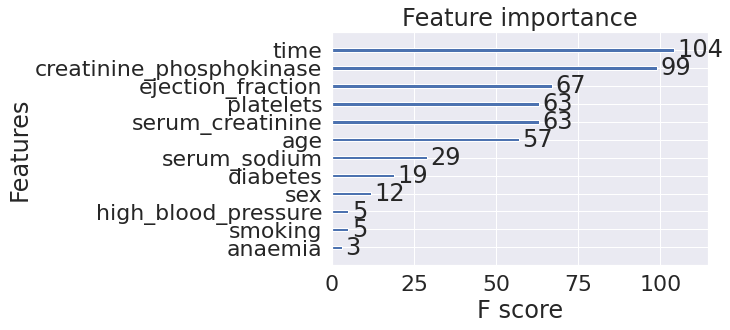

In [85]:
from xgboost import plot_importance
plot_importance(xgb)

# XGboost use 2 important features


In [86]:
xgb2 = XGBClassifier(random_state=38)

In [87]:
X_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,58.000000,0,582,1,25,0,504000.000000,1.000000,138,1,0,205
1,70.000000,0,161,0,25,0,244000.000000,1.200000,142,0,0,66
2,42.000000,1,86,0,35,0,365000.000000,1.100000,139,1,1,201
3,82.000000,1,855,1,50,1,321000.000000,1.000000,145,0,0,30
4,87.000000,1,149,0,38,0,262000.000000,0.900000,140,1,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...
295,58.756685,0,349,0,21,0,113529.413463,2.651337,128,1,0,71
296,57.496532,1,444,0,22,0,70835.259948,2.149422,135,1,0,133
297,74.340887,0,1184,1,42,0,319014.304057,1.028367,143,0,0,82
298,71.001608,0,582,0,20,0,265666.398629,1.433521,132,1,0,49


In [88]:
xgb2.fit(X_train[['time','creatinine_phosphokinase']],y_train)

XGBClassifier(random_state=38)

In [89]:
xgb_pred2 = xgb2.predict(X_test[['time','creatinine_phosphokinase']])

In [90]:
metrics(xgb_pred2,y_test)

,Predicted Y=0,Predicted Y=1
True Y=0,45,18
True Y=1,8,19


Accuracy: 0.7111111111111111
Sensitivity: 0.7037037037037037
Specificity: 0.7142857142857143
Precision: 0.5135135135135135
ROC-AUC: 0.7089947089947091
F1 score: 0.5938


2 features may have led to underfitting

#Xgboost 5 important features


In [91]:
xgb3 = XGBClassifier(random_state=3)

In [92]:
xgb3.fit(X_train[['time','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','age']],y_train)

XGBClassifier(random_state=3)

In [93]:
xgb_pred3 = xgb3.predict(X_test[['time','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','age']])

In [94]:
metrics(xgb_pred3,y_test)

,Predicted Y=0,Predicted Y=1
True Y=0,45,13
True Y=1,8,24


Accuracy: 0.7666666666666667
Sensitivity: 0.75
Specificity: 0.7758620689655172
Precision: 0.6486486486486487
ROC-AUC: 0.7629310344827587
F1 score: 0.6957


Still not better than all features used

# Hyperparameter tune xgboost

In [ ]:
gridsearch_params = [{
    'max_depth':[4,5,6,7,8],
    'min_child_weight':[7,9,11,13],
    'gamma':[0.05,0.1,0.25],
    'reg_lambda':[0.05,0.1,0.25],
    'scale_pos_weight':[0.5,1],
    'eta':[0.05,0.1,0.3],
    'subsample':[0.5,0.9],
    'colsample_bytree':[0.5,0.7]
    }]

In [ ]:
optimal_params = GridSearchCV(
                estimator=XGBClassifier(objective='binary:logistic',
                seed=41),
                param_grid=gridsearch_params,
                scoring='roc_auc',
                verbose=2,
                cv=5)


In [ ]:
optimal_params.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
[CV] END colsample_bytree=0.7, eta=0.1, gamma=0.1, max_depth=8, min_child_weight=7, reg_lambda=0.25, scale_pos_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.1, gamma=0.1, max_depth=8, min_child_weight=7, reg_lambda=0.25, scale_pos_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.1, gamma=0.1, max_depth=8, min_child_weight=7, reg_lambda=0.25, scale_pos_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.1, gamma=0.1, max_depth=8, min_child_weight=7, reg_lambda=0.25, scale_pos_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.1, gamma=0.1, max_depth=8, min_child_weight=7, reg_lambda=0.25, scale_pos_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, eta=0.1, gamma=0.1, max_depth=8, min_child_weight=7, reg_lambda=0.25, scale_pos_weight=0.5, subsample=0.9; total time=   0.0s
[CV] EN

GridSearchCV(cv=5, estimator=XGBClassifier(seed=41),
             param_grid=[{'colsample_bytree': [0.5, 0.7],
                          'eta': [0.05, 0.1, 0.3], 'gamma': [0.05, 0.1, 0.25],
                          'max_depth': [4, 5, 6, 7, 8],
                          'min_child_weight': [7, 9, 11, 13],
                          'reg_lambda': [0.05, 0.1, 0.25],
                          'scale_pos_weight': [0.5, 1],
                          'subsample': [0.5, 0.9]}],
             scoring='roc_auc', verbose=2)

In [ ]:
optimal_params.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.05,
 'gamma': 0.1,
 'max_depth': 4,
 'min_child_weight': 7,
 'reg_lambda': 0.25,
 'scale_pos_weight': 1,
 'subsample': 0.9}

In [ ]:
xgb_tuned = XGBClassifier(max_depth=4,colsample_bytree=0.5, eta=0.05,gamma=0.1, min_child_weight=7,reg_lambda=0.25,scale_pos_weight=1,subsample=0.9)

In [ ]:
xgb_tuned.fit(X_train,y_train)

XGBClassifier(colsample_bytree=0.5, eta=0.05, gamma=0.1, max_depth=4,
              min_child_weight=7, reg_lambda=0.25, subsample=0.9)

In [ ]:
xgb_pred2 = xgb_tuned.predict(X_test)

In [ ]:
metrics(y_test,xgb_pred2) # same as default...

,Predicted Y=0,Predicted Y=1
True Y=0,47,6
True Y=1,12,25


Accuracy: 0.8
Sensitivity: 0.6756756756756757
Specificity: 0.8867924528301887
Precision: 0.8064516129032258
ROC-AUC: 0.7812340642529322
F1 score: 0.7353


# Save xgboost as pickle

In [ ]:
import pickle

In [ ]:
pickle.dump(xgb,open("xgb_model","wb"))